In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epirecipes/utils.py
/kaggle/input/epirecipes/full_format_recipes.json
/kaggle/input/epirecipes/epi_r.csv
/kaggle/input/epirecipes/recipe.py


In [ ]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


# Importing libraries

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [ ]:
spark= SparkSession.builder.appName("Recipes ML Model").getOrCreate()

# Loading and Exploring data

In [ ]:
df=spark.read.csv('/kaggle/input/epirecipes/epi_r.csv',inferSchema=True,header=True)

In [ ]:
print(df.count(),len(df.columns))

20057 680


Exception ignored in: <function JavaWrapper.__del__ at 0x7fd0d4343cb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/ml/wrapper.py", line 42, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'MinMaxScaler' object has no attribute '_java_obj'


In [ ]:
df.printSchema()

root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- #cakeweek: double (nullable = true)
 |-- #wasteless: double (nullable = true)
 |-- 22-minute meals: double (nullable = true)
 |-- 3-ingredient recipes: double (nullable = true)
 |-- 30 days of groceries: double (nullable = true)
 |-- advance prep required: double (nullable = true)
 |-- alabama: double (nullable = true)
 |-- alaska: double (nullable = true)
 |-- alcoholic: double (nullable = true)
 |-- almond: double (nullable = true)
 |-- amaretto: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- anniversary: double (nullable = true)
 |-- anthony bourdain: double (nullable = true)
 |-- aperitif: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullable = true)


# Function to rename column

In [ ]:
def sanitize_column_name(name):
    """drops unwanted character's, replaces spaces and other symbols with an underscore. All letters in lower case"""
    answer= name
    for orignal_value,replaced_value in ((" ","_"), ("-","_"),("/","_"),("&","and"),("#","")):
        answer= answer.replace(orignal_value,replaced_value)
    return "".join([char for char in answer if char.isalpha() or char.isdigit() or char=="_"])

In [ ]:
df_new= df.toDF(*[sanitize_column_name(name)for name in df.columns])

In [ ]:
df_new.columns

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 'cakeweek',
 'wasteless',
 '22_minute_meals',
 '3_ingredient_recipes',
 '30_days_of_groceries',
 'advance_prep_required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony_bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple_juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian_pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back_to_school',
 'backyard_bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille_day',
 'bean',
 'beef',
 'beef_rib',
 'beef_shank',
 'beef_tenderloin',
 'beer',
 'beet',
 'bell_pepper',
 'berry',
 'beverly_hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue_cheese',
 'blueberry',
 'boil',
 'bok_choy',
 'bon_appétit',
 'bon_apptit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisket',

# Finding binary column

In [ ]:
is_binary= df_new.agg(*[(F.size(F.collect_set(x)) == 2).alias(x) for x in df_new.columns]).toPandas()

In [ ]:
is_binary.unstack()

title       0    False
rating      0    False
calories    0    False
protein     0    False
fat         0    False
                 ...  
cookbooks   0     True
leftovers   0     True
snack       0     True
snack_week  0     True
turkey      0     True
Length: 680, dtype: bool

In [ ]:
df_new.where("cakeweek > 1.0 or wasteless > 1.0").select("title", "rating", "wasteless", "cakeweek", df_new.columns[-1]).show()

+--------------------+--------------------+---------+--------+------+
|               title|              rating|wasteless|cakeweek|turkey|
+--------------------+--------------------+---------+--------+------+
|"Beet Ravioli wit...| Aged Balsamic Vi...|      0.0|   880.0|   0.0|
|"Seafood ""Catapl...|            Vermouth|   1439.0|    24.0|   0.0|
|"""Pot Roast"" of...| Aunt Gloria-Style "|      0.0|  1188.0|   0.0|
+--------------------+--------------------+---------+--------+------+



In [ ]:
df= df_new.where((F.col("cakeweek").isin([0.0, 1.0]) | F.col("cakeweek").isNull()) 
                 & (F.col("wasteless").isin([0.0,1.0]) | F.col("wasteless").isNull()))

In [ ]:
print(df.count() , len(df.columns))

20054 680


In [ ]:
IDENTIFIERS = ["title"]
CONTINUOUS_COLUMNS = ["rating", "calories","protein", "fat", "sodium"]
TARGET_COLUMN= ["dessert"]
BINARY_COLUMNS = [x for x in df.columns
                 if x not in CONTINUOUS_COLUMNS
                 and x not in TARGET_COLUMN
                 and x not in IDENTIFIERS]

In [ ]:
df=df.dropna(how="all",subset= [x for x in df.columns if x not in IDENTIFIERS])

In [ ]:
df= df.dropna(subset=TARGET_COLUMN)
print(df.count() , len(df.columns))

20049 680


In [ ]:
df = df.fillna(0.0, subset= BINARY_COLUMNS)
print(df.where(F.col(BINARY_COLUMNS[0]).isNull()).count())


0


# Getting rid of non numeric values in rating & calories columns

In [ ]:
from typing import Optional
@F.udf(T.BooleanType())
def is_a_number(value: Optional[str]) -> bool:
    if not value:
        return True
    try:
        _=float(value)
    except ValueError:
        return False
    return  True



In [ ]:
for column in ["rating", "calories"]:
    df= df.where(is_a_number(F.col(column)))
    df= df.withColumn(column, F.col(column).cast(T.DoubleType()))
print(df.count() , len(df.columns))

20048 680


In [ ]:
for col in ["rating", "calories","protein", "fat", "sodium"]:
    df.select(col).summary("mean","stddev","min","1%","5%","50%","95%","99%","max").show()
    

+-------+------------------+
|summary|            rating|
+-------+------------------+
|   mean| 3.714460295291301|
| stddev|1.3409187660508954|
|    min|               0.0|
|     1%|               0.0|
|     5%|               0.0|
|    50%|             4.375|
|    95%|               5.0|
|    99%|               5.0|
|    max|               5.0|
+-------+------------------+

+-------+------------------+
|summary|          calories|
+-------+------------------+
|   mean|6324.0634571930705|
| stddev| 359079.8369634015|
|    min|               0.0|
|     1%|              18.0|
|     5%|              62.0|
|    50%|             331.0|
|    95%|            1316.0|
|    99%|            3203.0|
|    max|       3.0111218E7|
+-------+------------------+

+-------+------------------+
|summary|           protein|
+-------+------------------+
|   mean|100.17385283565179|
| stddev| 3840.680997128737|
|    min|               0.0|
|     1%|               0.0|
|     5%|               0.0|
|    50%|   

In [ ]:
maximum= {"calories":3203.0,
         "protein":173.0,
         "fat":207.0,
         "sodium":5661.0}
for k,v in maximum.items():
    df= df.withColumn(k, F.least(F.col(k),F.lit(v)))
def compute_mean(df,include):
    return (df.agg(*(F.avg(c).alias(c) for c in include)).first().asDict())
computed_mean= compute_mean(df,["calories","protein", "fat", "sodium"])

In [ ]:
df=df.fillna(computed_mean)

In [ ]:
for col in ["rating", "calories","protein", "fat", "sodium"]:
    df.select(col).summary("mean","stddev","min","1%","5%","50%","95%","99%","max").show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|   mean| 3.714460295291301|
| stddev|1.3409187660508954|
|    min|               0.0|
|     1%|               0.0|
|     5%|               0.0|
|    50%|             4.375|
|    95%|               5.0|
|    99%|               5.0|
|    max|               5.0|
+-------+------------------+

+-------+------------------+
|summary|          calories|
+-------+------------------+
|   mean|1035.4932162809257|
| stddev| 1182.704964910487|
|    min|               0.0|
|     1%|              20.0|
|     5%|              75.0|
|    50%|             445.0|
|    95%|            3203.0|
|    99%|            3203.0|
|    max|            3203.0|
+-------+------------------+

+-------+------------------+
|summary|           protein|
+-------+------------------+
|   mean|51.860434956105344|
| stddev|  67.1718812452042|
|    min|               0.0|
|     1%|               0.0|
|     5%|               1.0|
|    50%|   

In [ ]:
inst_sum_of_binary_columns= [F.sum(F.col(x)) for x in BINARY_COLUMNS]
sum_of_binary_columns= (df.select(*inst_sum_of_binary_columns)).head().asDict()
num_rows= df.count()
too_rare_features= [k for k,v in sum_of_binary_columns.items() if v <10 or v > (num_rows-10)]
len(too_rare_features)

167

In [ ]:
BINARY_COLUMNS= list(set(BINARY_COLUMNS)- set(too_rare_features))

# Feature Engineering

## Creating new feature that computes percentage of calories to protein & fats
### 1) Protein Ratio : There are 4 kcal per grams of protein
### 2) Fat Ratio : There are 9 kcal per grams of fat

In [ ]:
df = df.withColumn("protein_ratio", F.col("protein") * 4 / F.col("calories")).withColumn("fat_ratio",F.col("fat") * 9 / F.col("calories"))
df= df.fillna(0.0,subset= ["protein_ratio","fat_ratio"])

In [ ]:
CONTINUOUS_COLUMNS += ["protein_ratio", "fat_ratio"]

# Removing Highly Correlated Features
1. If 2 features are highly correlated, it means that they provides almost same information.
2. Highly correlated features rarely improve accuracy, yet complicates the model.

## Using Vector Assembler for Continuos features

In [ ]:
from pyspark.ml.feature import VectorAssembler
continuous_features= VectorAssembler(inputCols=CONTINUOUS_COLUMNS,outputCol= "continuous_features")
vector_variable= continuous_features.transform(df)
vector_variable.select("continuous_features").show(3,False)

+---------------------------------------------------------------------+
|continuous_features                                                  |
+---------------------------------------------------------------------+
|[2.5,426.0,30.0,7.0,559.0,0.28169014084507044,0.14788732394366197]   |
|[4.375,403.0,18.0,23.0,1439.0,0.17866004962779156,0.5136476426799007]|
|[3.75,165.0,6.0,7.0,165.0,0.14545454545454545,0.38181818181818183]   |
+---------------------------------------------------------------------+
only showing top 3 rows



## Creating Correlation matrix in PySpark

In [ ]:
from pyspark.ml.stat import Correlation
correlation= Correlation.corr(continuous_features.transform(df),"continuous_features")
correlation_array=correlation.head()[0].toArray()
correlation_pd=pd.DataFrame(correlation_array , index = CONTINUOUS_COLUMNS ,columns = CONTINUOUS_COLUMNS)



# Feature scaling

In [ ]:
from pyspark.ml.feature import MinMaxScaler
CONTINUOUS_NB= [x for x in CONTINUOUS_COLUMNS if "ratio" not in x]
continuous_assembler= VectorAssembler(inputCols= CONTINUOUS_NB , outputCol = "continuous")
df_features= continuous_assembler.transform(df)
continuous_scaler= MinMaxScaler(inputCol="continuous", outputCol= "continuous_scaled")
df_features= continuous_scaler.fit(df_features).transform(df_features)

In [ ]:
df_features.select("continuous_scaled").show(3,False)

+-----------------------------------------------------------------------------------------+
|continuous_scaled                                                                        |
+-----------------------------------------------------------------------------------------+
|[0.5,0.13300031220730565,0.17341040462427745,0.033816425120772944,0.09874580462815757]   |
|[0.875,0.12581954417733376,0.10404624277456646,0.1111111111111111,0.2541953718424307]    |
|[0.75,0.051514205432407124,0.03468208092485549,0.033816425120772944,0.029146793852676208]|
+-----------------------------------------------------------------------------------------+
only showing top 3 rows



# Assembling final data with vector columns

In [ ]:
model_binary_assembler= VectorAssembler(inputCols= BINARY_COLUMNS + ["continuous_scaled"] + ["protein_ratio", "fat_ratio"], outputCol="features")
df_model= model_binary_assembler.transform(df_features)
df_model.select("title","dessert","features").show(5,truncate=30)

+------------------------------+-------+------------------------------+
|                         title|dessert|                      features|
+------------------------------+-------+------------------------------+
|Lentil, Apple, and Turkey W...|    0.0|(680,[68,95,99,122,144,164,...|
|Boudin Blanc Terrine with R...|    0.0|(680,[1,268,293,310,428,479...|
| Potato and Fennel Soup Hodge |    0.0|(680,[28,33,95,182,324,346,...|
|Mahi-Mahi in Tomato Olive S...|    0.0|(680,[61,115,170,236,267,26...|
|     Spinach Noodle Casserole |    0.0|(680,[47,95,128,182,293,371...|
+------------------------------+-------+------------------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features",labelCol="dessert",predictionCol="prediction")
train,test=df_model.randomSplit([0.7,0.3])
train.cache()
lrModel= lr.fit(train)
predictions= lrModel.transform(test)

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabel= predictions.select("prediction", "dessert").rdd
metrics = MulticlassMetrics(predictionAndLabel)
confusion_matrix = pd.DataFrame(metrics.confusionMatrix().toArray(),
                               index= ["dessert=0", "dessert=1"],
                               columns= ["predicted=0","predicted=1"])
print(confusion_matrix)

           predicted=0  predicted=1
dessert=0       4916.0         81.0
dessert=1         86.0        968.0


In [ ]:
print(f"Model Precision: {metrics.precision(1.0)}")
print(f"Model Recall: {metrics.recall(1.0)}")
print(f"Model f1-score: {metrics.fMeasure(1.0)}")

Model Precision: 0.9227836034318398
Model Recall: 0.9184060721062619
Model f1-score: 0.9205896338563956


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
trainingSummary= lrModel.summary
evaluator= BinaryClassificationEvaluator(labelCol="dessert",
                                        rawPredictionCol="rawPrediction",
                                        metricName="areaUnderROC")
AUC=evaluator.evaluate(predictions)
print(" AREA UNDER ROC = {AUC}")

0.9932599977443773


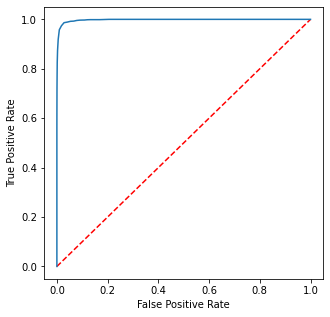

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],"r--")
plt.plot(
lrModel.summary.roc.select("FPR").collect(),
lrModel.summary.roc.select("TPR").collect())
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
predictions.columns

[Row(title='"Flounder ""Kiev"" "', rating=3.75, calories=852.0, protein=36.0, fat=66.0, sodium=965.0, cakeweek=0.0, wasteless=0.0, 22_minute_meals=0.0, 3_ingredient_recipes=0.0, 30_days_of_groceries=0.0, advance_prep_required=0.0, alabama=0.0, alaska=0.0, alcoholic=0.0, almond=0.0, amaretto=0.0, anchovy=0.0, anise=0.0, anniversary=0.0, anthony_bourdain=0.0, aperitif=0.0, appetizer=0.0, apple=0.0, apple_juice=0.0, apricot=0.0, arizona=0.0, artichoke=0.0, arugula=0.0, asian_pear=0.0, asparagus=0.0, aspen=0.0, atlanta=0.0, australia=0.0, avocado=0.0, back_to_school=0.0, backyard_bbq=0.0, bacon=0.0, bake=0.0, banana=0.0, barley=0.0, basil=0.0, bass=0.0, bastille_day=0.0, bean=0.0, beef=0.0, beef_rib=0.0, beef_shank=0.0, beef_tenderloin=0.0, beer=0.0, beet=0.0, bell_pepper=0.0, berry=0.0, beverly_hills=0.0, birthday=0.0, biscuit=0.0, bitters=0.0, blackberry=0.0, blender=0.0, blue_cheese=0.0, blueberry=0.0, boil=0.0, bok_choy=0.0, bon_appétit=0.0, bon_apptit=0.0, boston=0.0, bourbon=0.0, bra